New York Institute of Technology<br>
Course: DTSC 870 / Spring 2022<br>
Advisor: Dr. Cao<br>
Team: Michael Trzaskoma, Hui (Henry) Chen

----

This notebook is meant to fetch all necessary dataset for the project. Therefore, this is part of Phase I of the project.

In [ ]:
# setup to see the execution time in each cell

!pip install ipython-autotime tqdm
%load_ext autotime

time: 2.84 ms (started: 2022-02-11 16:04:36 +00:00)


# Mount the driver

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now, let's see what's the current directory.

In [ ]:
import os

print(os.getcwd())

/content


## Change dataset dir

In [ ]:
# feel free to change the dataset to your desired directory:

ROOT_DIR = "/content/drive/MyDrive/Spring 2022/DTSC 870/Code" #HC Directory
# ROOT_DIR = "/content/drive/MyDrive/DTSC 870/Code" #MT Directory

DATASET_DIR = ROOT_DIR + "/datasets"
# DATASET_DIR = "/content/drive/MyDrive/Spring 2022/DTSC 870/Code/datasets"

os.chdir(ROOT_DIR)

print("Current directory is: {}".format(os.getcwd()))

Current directory is: /content/drive/MyDrive/Spring 2022/DTSC 870/Code


List of all files under current directory.

In [ ]:
!pip install directory_structure

     |████████████████████████████████| 174 kB 5.1 MB/s 
  Created wheel for emoji: filename=emoji-1.6.3-py3-none-any.whl size=170298 sha256=28fbd89a5a543ff80efdf473286a6aa769719c1bf08f93c90639d131d42c3b8a
  Stored in directory: /root/.cache/pip/wheels/03/8b/d7/ad579fbef83c287215c0caab60fb0ae0f30c4d7ce5f580eade
Successfully built emoji
time: 7.07 s (started: 2022-02-11 16:04:53 +00:00)


In [ ]:
from directory_structure import Tree

print(Tree(os.getcwd()))

📂 Code
|_📁 datasets
|_📁 keys
|_📄 02__dataset_visualizations.ipynb
|_📄 01__fetch_data.ipynb
|_📄 03__MRI_Classifier_a.ipynb
time: 42 ms (started: 2022-02-11 16:05:02 +00:00)


## Create dataset directories.

In [ ]:
# create the directories if not exist
if not os.path.exists("./datasets/01_MRI"):
  os.mkdir("./datasets/01_MRI")
  os.mkdir("./datasets/02_FER")
  os.mkdir("./datasets/03_F_MINST")

DATASET_01 = ROOT_DIR + "/datasets/01_MRI/Brain_tumor_images"
DATASET_02 = ROOT_DIR + "/datasets/02_FER"
DATASET_03 = ROOT_DIR + "/datasets/03_F_MINST"

# Download datasets

## Setup

The easiest way to download the dataset from the Kaggle would be through the Kaggle API. Ref: https://www.kaggle.com/general/74235

In [ ]:
!pip install -q kaggle

time: 4.86 s (started: 2022-02-10 16:34:48 +00:00)


In [ ]:
KAGGLE_KEY = ROOT_DIR + "/keys/kaggle.json"
print(KAGGLE_KEY)

/content/drive/MyDrive/Spring 2022/DTSC 870/Code/keys/kaggle.json
time: 3.45 ms (started: 2022-02-10 16:34:52 +00:00)


Create a kaggle environment and then copy the kaggle key to that directory. Lastly, modify the key's permission.

In [ ]:
!mkdir ~/.kaggle

!cp /content/drive/MyDrive/'Spring 2022'/'DTSC 870'/Code/keys/kaggle.json ~/.kaggle/

!chmod 600  ~/.kaggle/kaggle.json

time: 675 ms (started: 2022-02-10 16:34:59 +00:00)


Output a list of dataset to test if it's working.

In [ ]:
!kaggle datasets list

ref                                                         title                                             size  lastUpdated          downloadCount  
----------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  
nkitgupta/jigsaw-regression-based-data                      Jigsaw Regression Based Data                       3GB  2022-02-05 20:51:56            872  
prasertk/netflix-subscription-price-in-different-countries  Netflix subscription fee in different countries    3KB  2022-01-15 07:06:09           2763  
yasserh/wine-quality-dataset                                Wine Quality Dataset                              21KB  2022-01-15 19:15:11           2375  
sanjeetsinghnaik/top-1000-highest-grossing-movies           Top 1000 Highest Grossing Movies                 106KB  2022-01-15 16:26:14           1763  
iamsouravbanerjee/analytics-industry-salaries-2022-india    Data Professionals Sal

---

### Train and Test ratio

We want to split the Normal and Tumor into train and test set with ratio of 0.7:0.3.

In [ ]:
TRAIN_K = 0.7
TEST_K = 1 - TRAIN_K

time: 1.18 ms (started: 2022-02-11 16:05:31 +00:00)


## Utility Func

In [ ]:
import os

def create_train_test_dir(sub_dir, class_):
  # sub_dir : train/test
  # class_ : class label of the dataset
  # print(os.getcwd())
  # dir = dataset_dir + sub_dir + "/" + class_
  dir = os.getcwd() + sub_dir + "/" + class_

  if not os.path.exists(dir):
    os.makedirs(dir)

In [ ]:
import numpy as np
import shutil
from tqdm import tqdm

def set_move2(class_, data_source):
  '''
    Split the given dataset directory into train and test sets 
    based on the given classes.

    class_ : dataset prelabled class
    data_source : the root direcotry of the dataset

    Code ref: https://www.kaggle.com/questions-and-answers/102677
  '''

  for c in class_:
    print(f"################### {c} ################### ")
    '''
      Create the necessary directories before we split.
      
      NOTE: we have to create direcotires here because "class_" is dynamically
      scan the data source directory. Therefore, if we create "train" and 
      "test" folders prior the split, the scan will count "train" and "test" as 
      part of the class, which will throw an error as this func try to 
      copy into "<data source root>/train/train" (or test) directory.
    '''

    if not os.path.exists(data_source +'/train'):
      os.mkdir(data_source +'/train')
      os.mkdir(data_source +'/test')
      
    if not os.path.exists(data_source +'/train/'+c):
      os.makedirs(data_source +'/train/'+c)
      os.makedirs(data_source +'/test/'+c)
    
    # specify the datasource
    # e.g., datasets/Brain_tumor_images/<class>
    source = data_source + "/" + c

    # get all file names
    all_file_names = os.listdir(source)

    # randomize the files by shuffling it
    # aka random sampling
    np.random.shuffle(all_file_names)

    # split the file names in the given test ratio
    train_file_name, test_file_name = np.split(
        np.array(all_file_names), [int(len(all_file_names) * (1 - TEST_K))]
        )
    
    # assign absolute source directory to each train and test file array
    train_file_name = [source + "/" + name for name in train_file_name.tolist()]
    test_file_name = [source + "/" + name for name in test_file_name.tolist()]

    # copy the train and test files to the desired directories
    for name in tqdm(train_file_name):
      shutil.copy(name, data_source +'/train/' + c)

    for name in tqdm(test_file_name):
      shutil.copy(name, data_source +'/test/' + c)
  
  print("\nAll jobs are done!")


In [ ]:
from tqdm import tqdm

def merge_sets(class_, root_dir):
  '''
    Merge the train and test sets.

    class_ : dataset prelabled class
    data_source : the root direcotry of the dataset

    Code ref: https://www.kaggle.com/questions-and-answers/102677
  '''
  
  # since the dataset itself already splitted into train and test sets
  # we need to manually specify the directory in order to merge all of them

  sub_dir = [root_dir+"/train", root_dir+"/test"]

  # the train and test set loop
  for sub in sub_dir:
    print(f"################### {sub} ################### ")
    # the class loop
    for c in class_:
      print(f"Class: {c} ")
      if not os.path.exists(root_dir +'/merge/'+c):
        os.makedirs(root_dir +'/merge/'+c)
      
      # specify the datasource
      # e.g., datasets/Brain_tumor_images/<class>
      source = sub + "/" + c

      # get all file names
      all_file_names = os.listdir(source)
      
      # assign absolute source directory to each train and test file array
      files_ = [source + "/" + name for name in all_file_names]

      # copy the train and test files to the desired directories
      for name in tqdm(files_):
        shutil.copy(name, root_dir +'/merge/' + c)
  
  print("\nAll jobs are done!")

In [ ]:
def remove_unused_dir(dir_path, class_):
  '''
    Remove unused directories from a given dir path. It will remove all dir 
    and sub-dir along with all content inside those sub-dir.

    NOTE: it will only keep "train" and "test" dir.

    dir_path : input root dir
  '''

  # redir to the given path
  os.chdir(dir_path)

  # retrieve a list of folder names in that dir
  # list_dir_name = [name for name in os.listdir(os.getcwd())]

  for c in class_:
    # remove everything except the "train" and "test" dir
    if not str(c).lower == "train" or not str(c).lower == "test":
      shutil.rmtree(os.getcwd()+"/"+c)
      # print("The dir is {}".format(os.getcwd() + "/" + c))
  
  print("\nAll jobs are done!")

## MRI Based Brain Tumor Images

URL: https://www.kaggle.com/mhantor/mri-based-brain-tumor-images

In [ ]:
os.chdir(DATASET_01)

time: 301 ms (started: 2022-02-10 16:20:45 +00:00)


In order to download and unzip the dataset from a competition, we need to provide the URL of the dataset along with the following command line:

```
!kaggle datasets download <URL suffix: everything afer "kaggle.com/"> -p <desired directory to save the dataset> --unzip
```

In [ ]:
print(DATASET_01)

/content/drive/MyDrive/DTSC 870/Code/datasets/01_MRI


In [ ]:
# !kaggle competitions download -c 'MRI-Based-Brain-Tumor-Images'

!kaggle datasets download mhantor/mri-based-brain-tumor-images/download -p /content/drive/MyDrive/'Spring 2022'/'DTSC 870'/Code/datasets/01_MRI --unzip

  0% 0.00/8.99M [00:00<?, ?B/s]
100% 8.99M/8.99M [00:00<00:00, 149MB/s]
time: 3.72 s (started: 2022-02-06 03:31:57 +00:00)


Now let's see if we have downloaded all MRI dataset.

In [ ]:
# os.chdir("./Brain_tumor_images")
print(Tree(os.getcwd()))

📂 Brain_tumor_images
|_📁 train
|_📁 test
time: 8.78 ms (started: 2022-02-10 16:20:47 +00:00)


In [ ]:
os.chdir(os.getcwd() + "/Normal")
print(Tree(os.getcwd()))

📂 train
|_📁 Normal
|_📁 Tumor
time: 12.3 ms (started: 2022-02-10 16:20:59 +00:00)


In [ ]:
os.chdir("../Tumor")
print(Tree(os.getcwd()))

### Generate the train and test set

Get a list of class and # of records in each class.

In [ ]:
import random
import glob

# get the length of tumor and normal
#tumor_len = len([file for file in os.scandir(DATASET_01+"/Tumor")])
tumor_len = len([file for file in os.scandir(DATASET_01+"/Tumor")])
#normal_len = len([file for file in os.scandir(DATASET_01+"/Normal")])
normal_len = len([file for file in os.scandir(DATASET_01+"/Normal")])

# get a list class in MRI img data
#os.chdir(DATASET_01)
os.chdir(DATASET_01)

mri_classes = [file for file in os.listdir(os.getcwd())]

print(f"# of tumor img: {tumor_len}")
print(f"# of normal img: {normal_len}")
print(f"List of class in MRI image data: {mri_classes}")

# of tumor img: 230
# of normal img: 170
List of class in MRI image data: ['Normal', 'Tumor']
time: 23.6 ms (started: 2022-02-07 16:53:50 +00:00)


Create 'train' and 'test' directories.

In [ ]:
# create the train and test directories with class labels

dirs = ["/train", "/test"]

for c in mri_classes:
  for tar_k in dirs:
    # check the current dir back to MRI dataset
    os.chdir(DATASET_01)
    # print(os.getcwd())
    # print(f"For class: {c} and target: {tar_k}")
    create_train_test_dir(tar_k, c)

time: 43 ms (started: 2022-02-07 16:13:45 +00:00)


Perform the train and test split.

In [ ]:
# tumor_k = [{"k": round(tumor_len*TRAIN_K), "dir": "/train"}, {"k": round(tumor_len*TEST_K), "dir": "/test"}]
# normal_k = [{"k": round(normal_len*TRAIN_K), "dir": "/train"}, {"k": round(normal_len*TEST_K), "dir": "/test"}]

# #print(tumor_k)
# for c in mri_classes:

#   # since tumor and normal have different sample size, 
#   # we need to seprating specify the train and test split ratio
#   target = tumor_k
#   if str(c) == "Normal":
#     target = normal_k

#   for tar_k in target:
#     # check the current dir back to MRI dataset
#     os.chdir(DATASET_01+"/Brain_tumor_images")
#     # print(os.getcwd())
#     print(f"For class: '{c}' and target: {tar_k}")
#     set_move(c, tar_k)


# perform the train and test set spliting on "set_move" func version 2
set_move2(mri_classes, DATASET_01)

All operations are done!
time: 5.77 s (started: 2022-02-07 16:55:46 +00:00)


### Validate the split

Now let's validate the train and test split.

In [ ]:
tempTrain_ = DATASET_01+"/train"
tempTest_ = DATASET_01+"/test"

train_normal_len = len([i for i in os.listdir(tempTrain_+"/Normal")])
train_tumor_len = len([i for i in os.listdir(tempTrain_+"/Tumor")])

test_normal_len = len([i for i in os.listdir(tempTest_+"/Normal")])
test_tumor_len = len([i for i in os.listdir(tempTest_+"/Tumor")])

print("The total # of Normal and Tumor instances: {}, {}".format(normal_len, tumor_len))
print("Train set with \tNormal: {} \t Tumor: {} \nTest set with \tNormal: {} \t Tumor: {}".format(train_normal_len, train_tumor_len, test_normal_len, test_tumor_len))

The total # of Normal and Tumor instances: 170, 230
Train set with 	Normal: 118 	 Tumor: 161 
Test set with 	Normal: 52 	 Tumor: 69
time: 25.9 ms (started: 2022-02-07 17:19:52 +00:00)


Now, we need to remove the additional dir that are not in use.

e.g., `/Brain_tumor_imdages/<Normal/Tumor>` 

In [ ]:
# redirect to the correct dir
# os.chdir(DATASET_01)

# # remvoe the unused directories
# shutil.rmtree(DATASET_02+"/Normal")
# shutil.rmtree(DATASET_02+"/Tumor")

remove_unused_dir(DATASET_01, mri_classes)

## FER-2013

URL: https://www.kaggle.com/msambare/fer2013

In [ ]:
os.chdir(DATASET_02)
print("The current dir is: {}".format(os.getcwd()))

The current dir is: /content/drive/MyDrive/Spring 2022/DTSC 870/Code/datasets/02_FER
time: 3.23 ms (started: 2022-02-10 16:35:41 +00:00)


Downloading the dataset.

**Note: this process will take long as there are many images to unzip from the dataset.**

In [ ]:
!kaggle datasets download msambare/fer2013/download -p /content/drive/MyDrive/'Spring 2022'/'DTSC 870'/Code/datasets/02_FER --unzip

 94% 57.0M/60.3M [00:01<00:00, 42.4MB/s]
100% 60.3M/60.3M [00:01<00:00, 40.3MB/s]
time: 5min 52s (started: 2022-02-10 16:35:48 +00:00)


In [ ]:
os.chdir(DATASET_02 + "/train")
print(Tree(os.getcwd()))

📂 train
|_📁 angry
|_📁 disgust
|_📁 fear
|_📁 happy
|_📁 neutral
|_📁 sad
|_📁 surprise
time: 17.6 ms (started: 2022-02-10 16:41:47 +00:00)


In [ ]:
os.chdir("./angry")
print(Tree(os.getcwd()))

### Merge the sets

Here we are merging the predefined train and test sets so that we can resplit into the ratio that we want.

In [ ]:
# dynamically get a list of class

fer_classes = [i for i in os.listdir(DATASET_02+"/train")]

print(f"The classes in FER-2013 dataset: \n{fer_classes}")

The classes in FER-2013 dataset: 
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
time: 551 ms (started: 2022-02-10 20:36:03 +00:00)


Now, let's merge the train and test sets together.

<b>Note, this operation will take a bit of time to process!</b>

In [ ]:
merge_sets(fer_classes, DATASET_02)

################### /content/drive/MyDrive/Spring 2022/DTSC 870/Code/datasets/02_FER/train ################### 
Class: angry 


100%|██████████| 3995/3995 [00:57<00:00, 69.28it/s]


Class: disgust 


100%|██████████| 436/436 [00:05<00:00, 81.35it/s]


Class: fear 


100%|██████████| 4097/4097 [00:59<00:00, 69.44it/s]


Class: happy 


100%|██████████| 7215/7215 [01:57<00:00, 61.52it/s]


Class: neutral 


100%|██████████| 4965/4965 [01:12<00:00, 68.41it/s]


Class: sad 


100%|██████████| 4830/4830 [01:09<00:00, 69.00it/s]


Class: surprise 


100%|██████████| 3171/3171 [00:43<00:00, 72.81it/s]


################### /content/drive/MyDrive/Spring 2022/DTSC 870/Code/datasets/02_FER/test ################### 
Class: angry 


100%|██████████| 958/958 [00:15<00:00, 61.70it/s]


Class: disgust 


100%|██████████| 111/111 [00:01<00:00, 80.82it/s]


Class: fear 


100%|██████████| 1024/1024 [00:17<00:00, 57.81it/s]


Class: happy 


100%|██████████| 1774/1774 [00:34<00:00, 51.07it/s]


Class: neutral 


100%|██████████| 1233/1233 [00:21<00:00, 57.25it/s]


Class: sad 


100%|██████████| 1247/1247 [00:22<00:00, 56.55it/s]


Class: surprise 


100%|██████████| 831/831 [00:13<00:00, 60.83it/s]

All jobs are done!
time: 9min 13s (started: 2022-02-10 16:44:43 +00:00)


In [ ]:
# now remove the train and test set

shutil.rmtree(DATASET_02+"/train")
shutil.rmtree(DATASET_02+"/test")

time: 26.7 ms (started: 2022-02-07 23:43:47 +00:00)


### Generate the train and test set

Now, we need to split the dataset into the ratio that we want, which is 0.7:0.3.

In [ ]:
set_move2(fer_classes, DATASET_02+"/merge")

################### angry ################### 


100%|██████████| 1486/1486 [00:14<00:00, 100.07it/s]


################### disgust ################### 


100%|██████████| 165/165 [00:01<00:00, 101.91it/s]


################### fear ################### 


100%|██████████| 1537/1537 [00:16<00:00, 92.42it/s]


################### happy ################### 


100%|██████████| 2697/2697 [00:27<00:00, 99.30it/s]


################### neutral ################### 


100%|██████████| 1860/1860 [00:20<00:00, 92.92it/s]


################### sad ################### 


100%|██████████| 1824/1824 [00:19<00:00, 95.32it/s]


################### surprise ################### 


100%|██████████| 1201/1201 [00:12<00:00, 94.63it/s]

All jobs are done!
time: 30min 39s (started: 2022-02-10 20:40:34 +00:00)


### Validate the split

After the split, the new directory for the FER-2013 dataset is `DATASET_02/merge/<train/test set>`.

In [ ]:
os.chdir(DATASET_02+"/merge/train")
print(Tree(os.getcwd()))

📂 train
|_📁 angry
|_📁 disgust
|_📁 fear
|_📁 happy
|_📁 neutral
|_📁 sad
|_📁 surprise
time: 695 ms (started: 2022-02-08 19:26:14 +00:00)


In [ ]:
os.chdir(DATASET_02+"/merge/test")
print(Tree(os.getcwd()))

📂 test
|_📁 angry
|_📁 disgust
|_📁 fear
|_📁 happy
|_📁 neutral
|_📁 sad
|_📁 surprise
time: 268 ms (started: 2022-02-08 19:26:51 +00:00)


In [ ]:
source = DATASET_02+"/merge/train/disgust"
source2 = DATASET_02+"/merge/test/disgust"

# get all file names
file_train_disgust = os.listdir(source)
file_test_disgust = os.listdir(source2)

np.random.shuffle(file_train_disgust)
np.random.shuffle(file_test_disgust)

print("Training set sample:")
for i in range(5, 10):
  print(file_train_disgust[i])

print("\n##############################\n")

print("Test set sample:")
for i in range(5, 10):
  print(file_test_disgust[i])

Training set sample:
Training_7975772.jpg
Training_33035381.jpg
Training_40778169.jpg
Training_5420780.jpg
Training_5151632.jpg

##############################

Test set sample:
Training_85886105.jpg
Training_2408820.jpg
Training_73540712.jpg
Training_39330477.jpg
Training_42657020.jpg
time: 45.4 ms (started: 2022-02-10 21:41:16 +00:00)


Now we need to remove the unused dir.

In [ ]:
remove_unused_dir(DATASET_02+"/merge", fer_classes)

All jobs are done!
time: 1min 16s (started: 2022-02-10 21:39:02 +00:00)


## Fashion-MNIST

For the Fashion-MNIST dataset, we can retrieve it through TensorFlow:

```
from tensorflow.keras.datasets.fashion_mnist import load_data
(images, labels), (_,_) = load_data()
```

In [ ]:
from tensorflow.keras.datasets.fashion_mnist import load_data

(x_train, y_train), (x_test, y_test) = load_data()

4431872/4422102 [==============================] - 0s 0us/step
time: 3.63 s (started: 2022-02-11 16:06:30 +00:00)


In [ ]:
print(x_train.shape)

(60000, 28, 28)
time: 1.96 ms (started: 2022-02-11 16:06:36 +00:00)


In [ ]:
print(x_test.shape)

(10000, 28, 28)
time: 1.35 ms (started: 2022-02-11 16:06:37 +00:00)


In [ ]:
print(y_train.shape)

(60000,)
time: 1.38 ms (started: 2022-02-11 16:06:38 +00:00)


In [ ]:
print(y_test.shape)

(10000,)
time: 1.43 ms (started: 2022-02-11 16:06:39 +00:00)


In [ ]:
for li in [x_train, x_test]:
  # print(x_train)
  # print(x_test)
  break

### Merge

In [ ]:
X = [i for i in x_train] + [i for i in x_test]
y = [i for i in y_train] + [i for i in y_test]

time: 33.6 ms (started: 2022-02-11 16:06:41 +00:00)


In [ ]:
print(len(X))
print(len(y))

70000
70000
time: 1.53 ms (started: 2022-02-11 16:06:43 +00:00)


In [ ]:
import numpy as np

fashion_classes = np.unique(y)

print(fashion_classes)

[0 1 2 3 4 5 6 7 8 9]
time: 15 ms (started: 2022-02-11 16:06:46 +00:00)


In [ ]:
ARR = []

for class_ in fashion_classes:
  ARR.append({"X": [], "y": class_})

time: 2.02 ms (started: 2022-02-11 18:50:49 +00:00)


In [ ]:
for item in ARR:
  print(item)

{'X': [], 'y': 0}
{'X': [], 'y': 1}
{'X': [], 'y': 2}
{'X': [], 'y': 3}
{'X': [], 'y': 4}
{'X': [], 'y': 5}
{'X': [], 'y': 6}
{'X': [], 'y': 7}
{'X': [], 'y': 8}
{'X': [], 'y': 9}
time: 5.76 ms (started: 2022-02-11 18:50:50 +00:00)


In [ ]:
def append_arr():
  for i in range(len(X)):
    ARR[y[i]]["X"].append(X[i])

append_arr()

time: 25.3 ms (started: 2022-02-11 18:50:58 +00:00)


In [ ]:
for i in range(5):
  print(ARR[0]["X"][i])
  print("#####################################################################")

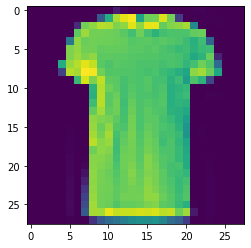

time: 291 ms (started: 2022-02-11 18:51:38 +00:00)


In [ ]:
import matplotlib.pyplot as plt

plt.imshow(ARR[0]["X"][i])

### Generate the train and test set

In [ ]:
DIR_NAME = "XXXX/fefe"
i = 0
filename = "{0}/{1:05d}.jpg".format(DIR_NAME,i)
filename

'XXXX/fefe/00000.jpg'

time: 5.96 ms (started: 2022-02-11 18:57:03 +00:00)


In [ ]:
from PIL import Image, ImageOps

def fashion_split(array_, dir):

  for i in range(len(array_)):
    print(f"########################## {i} ##########################")

    class_train_dir = dir+"/train/"+str(i)
    class_test_dir = dir+"/test/"+str(i)

    np.random.shuffle(array_[i]["X"])

    # split the file names in the given test ratio
    X_train, X_test = np.split(
        np.array(array_[i]["X"]), [int(len(array_[i]["X"]) * (1 - TEST_K))]
        )

    print(class_train_dir)

    # create necessary dir and sub-dir
    if os.path.exists(class_train_dir) == False:
      os.makedirs(class_train_dir)

    if os.path.exists(class_test_dir) == False:
      os.makedirs(class_test_dir)

    # Code ref: https://gist.github.com/uchidama/a75bd3b949b89f64ccc77a9a5de445a9
    j = 0
    for item in tqdm(X_train):
      filename = "{0}/{1:05d}.jpg".format(class_train_dir, j)
      im = Image.fromarray(item.astype('uint8'))
      im_invert = ImageOps.invert(im)
      im_invert.save(filename)
      j += 1

    k = 0
    for item in tqdm(X_test):
      filename = "{0}/{1:05d}.jpg".format(class_test_dir, k)
      im = Image.fromarray(item.astype('uint8'))
      im_invert = ImageOps.invert(im)
      im_invert.save(filename)
      k += 1


  #   train_df[str(class_)] = [item for item in X_train]
  #   test_df[str(class_)] = [item for item in X_test]
  #   # end for loop here

  # train_df.to_csv(dir+"/fashion_x_train.csv", header=False)
  # test_df.to_csv(dir+"/fashion_x_test.csv", header=False)

  print("\nAll jobs are done!")

time: 43.2 ms (started: 2022-02-11 19:45:12 +00:00)


In [ ]:
import numpy as np

arr1 = np.random.random_sample((5,))
arr2 = np.random.random_sample((5,))

for i in [arr1, arr2]:
  print(i)

[0.39817112 0.13013252 0.84102392 0.93975914 0.9662808 ]
[0.01864808 0.2710862  0.50886917 0.18996455 0.29267318]
time: 24.9 ms (started: 2022-02-11 19:31:29 +00:00)


In [ ]:
fashion_split(ARR, DATASET_03)

########################## 0 ##########################
/content/drive/MyDrive/Spring 2022/DTSC 870/Code/datasets/03_F_MINST/train/0


100%|██████████| 2100/2100 [00:15<00:00, 134.10it/s]


########################## 1 ##########################
/content/drive/MyDrive/Spring 2022/DTSC 870/Code/datasets/03_F_MINST/train/1


100%|██████████| 2100/2100 [00:21<00:00, 96.16it/s]


########################## 2 ##########################
/content/drive/MyDrive/Spring 2022/DTSC 870/Code/datasets/03_F_MINST/train/2


100%|██████████| 2100/2100 [00:19<00:00, 109.99it/s]


########################## 3 ##########################
/content/drive/MyDrive/Spring 2022/DTSC 870/Code/datasets/03_F_MINST/train/3


100%|██████████| 2100/2100 [00:15<00:00, 133.37it/s]


########################## 4 ##########################
/content/drive/MyDrive/Spring 2022/DTSC 870/Code/datasets/03_F_MINST/train/4


100%|██████████| 2100/2100 [00:15<00:00, 134.86it/s]


########################## 5 ##########################
/content/drive/MyDrive/Spring 2022/DTSC 870/Code/datasets/03_F_MINST/train/5


100%|██████████| 2100/2100 [00:21<00:00, 96.71it/s]


########################## 6 ##########################
/content/drive/MyDrive/Spring 2022/DTSC 870/Code/datasets/03_F_MINST/train/6


100%|██████████| 2100/2100 [00:15<00:00, 137.67it/s]


########################## 7 ##########################
/content/drive/MyDrive/Spring 2022/DTSC 870/Code/datasets/03_F_MINST/train/7


100%|██████████| 2100/2100 [00:15<00:00, 133.28it/s]


########################## 8 ##########################
/content/drive/MyDrive/Spring 2022/DTSC 870/Code/datasets/03_F_MINST/train/8


100%|██████████| 2100/2100 [00:15<00:00, 135.30it/s]


########################## 9 ##########################
/content/drive/MyDrive/Spring 2022/DTSC 870/Code/datasets/03_F_MINST/train/9


100%|██████████| 2100/2100 [00:15<00:00, 135.53it/s]


All jobs are done!
time: 10min 7s (started: 2022-02-11 19:45:18 +00:00)


### Validate the split

In [ ]:
fashion_train = pd.read_csv(DATASET_03+"/fashion_x_train.csv", header=None)

fashion_train.head(3)

In [ ]:
sample = fashion_train.iloc[1, 1]

time: 7.85 ms (started: 2022-02-11 17:45:25 +00:00)


In [ ]:
print(sample)

In [ ]:
from PIL import Image

sample_fashion = os.listdir(DATASET_03+"/train/0")
os.chdir(DATASET_03)
print(DATASET_03+"/train/0/"+sample_fashion[0])
flag = os.path.isfile(DATASET_03+"/train/5/"+sample_fashion[0])
print(flag)
im = Image.open(DATASET_03+"/train/5/"+sample_fashion[0])

# plt.imshow(DATASET_03+"/train/0/"+sample_fashion[0])
# for i in range(5):
#   plt.imshow(os.path.join("./train/0", sample_fashion[i]))
#   print(os.path.join("/train/0", sample_fashion[i]))

/content/drive/MyDrive/Spring 2022/DTSC 870/Code/datasets/03_F_MINST/train/0/00000.jpg
True


In [ ]:
im